In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import matplotlib as mpl 
import os
mpl.rc('text', usetex = True)
from scipy.fft import rfftn, irfftn,fftfreq

## Simulation details

In [18]:
N = 64
num_slabs = 64
nu = 1/800
isforcing = True

In [19]:
PI = np.pi
TWO_PI = 2*PI
Nf = N//2 + 1
Nd = np.round(2/3**0.5*Nf,0).astype(int)
Np = N
L = TWO_PI
X = Y = Z = np.linspace(0, L, N, endpoint= False)
dx,dy,dz = X[1]-X[0], Y[1]-Y[0], Z[1]-Z[0]
x, y, z = np.meshgrid(X, Y, Z, indexing='ij')

Kx = Ky = Kz = fftfreq(N,  1./N)*TWO_PI/L
Kz = Kz[:Nf]
kx,  ky,  kz = np.meshgrid(Kx,  Ky,  Kz,  indexing = 'ij')
k = (kx**2 + ky**2 + kz**2)**0.5


In [20]:
# loadPath = lambda t : pathlib.Path(f"/home/rajarshi.chattopadhyay/python/3D-DNS/data/N_{N}_Re_{np.round(1/nu,0)}/forced-from-zero/time_{t:.1f}")
# loadPath = lambda t : pathlib.Path(f"/home/rajarshi.chattopadhyay/python/3D-DNS/data/forced/N_128_Re_600.0/time_{t:.1f}")
loadPath = lambda t : pathlib.Path(f"./data/forced_{isforcing}/N_{N}_Re_{1/nu:.1f}/time_{t:.1f}")
times = [float(i.split("_")[-1]) for i in os.listdir(loadPath(0).parent) if "time" in i]
times.sort()
times[-1]

30.0

In [21]:

# np.load(f"/mnt/pfs/rajarshi.chattopadhyay/3D-DNS/data/zero-start/time_10.0/Fields_56.npz")["u"].shape
u = np.zeros((N,N,N))
v = np.zeros((N,N,N))
w = np.zeros((N,N,N))
# times = np.array(list(np.arange(0,200.5,10)) )#+  list(np.arange(50.9,100.5,1.0)))


## Time series + Kolmogorov Length scale

In [22]:
tload = times
ke = np.zeros(len(tload))
pe = np.zeros(len(tload))
eta = np.zeros(len(tload))
for ii,t in enumerate(tload):
    print('Loading Done for time:',t,end = '\r')

    # ke[ii] = np.sum(np.load(loadPath(t)/f"KE_spectrum.npz")["ek"])
    ek = np.load(loadPath(t)/f"Energy_spectrum.npz")["ek"]
    ke[ii] = np.sum(ek)
    eta[ii] =  (nu *np.sum(np.arange(len(ek))**2 * (2*ek)))
    # pe[ii] = np.sum(np.load(loadPath(t)/f"PE_spectrum.npz")["ek"])


Text(0, 0.5, '$\\eta$')

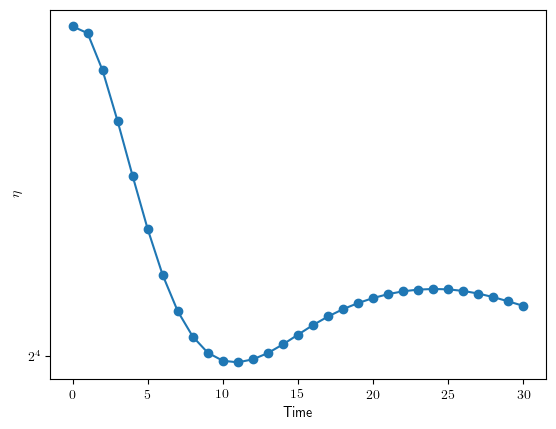

In [23]:
# plt.plot(tload,eta,'x-')
plt.plot(tload,ke,'o-')
# plt.plot(tload,pe,'o-')
# plt.plot(tload,pe + ke,'o-')
# plt.ylim(0,10)   
# plt.xlim(0,150) 
plt.yscale('log',base = 2)
plt.xlabel('Time')
plt.ylabel('$\eta$')

## Spectrum

(1e-10, 100)

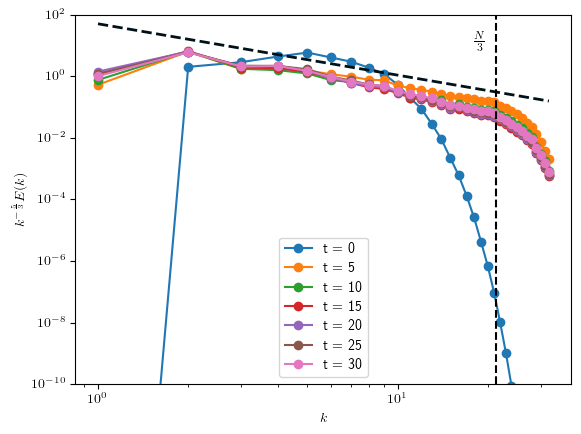

In [25]:
for t in [i for i in times[::5] if i<=30]:
    print('Loding Done for time:',t,end = '\r')
    # print(str(loadPath(t)))
    # for i in range(num_slabs):
    #     Fields = np.load(loadPath(t)/f"Fields_{i:.0f}.npz")
    #     # print(Fields.files)
    #     u[i*(N//num_slabs): (i+1)*(N//num_slabs),:]  = Fields["u"][:,:,:]
    #     v[i*(N//num_slabs): (i+1)*(N//num_slabs),:]  = Fields["v"][:,:,:]
    #     w[i*(N//num_slabs): (i+1)*(N//num_slabs),:]  = Fields["w"][:,:,:]
        
    # uk = rfftn(u)/(N**6/(TWO_PI**3*2))**0.5
    # vk = rfftn(v)/(N**6/(TWO_PI**3*2))**0.5
    # wk = rfftn(w)/(N**6/(TWO_PI**3*2))**0.5

    # uk[...,0] = 2**(-0.5)*uk[...,0]
    # vk[...,0] = 2**(-0.5)*vk[...,0]
    # wk[...,0] = 2**(-0.5)*wk[...,0]
    
    # uk[...,-1] = 2**(-0.5)*uk[...,-1]
    # vk[...,-1] = 2**(-0.5)*vk[...,-1]
    # wk[...,-1] = 2**(-0.5)*wk[...,-1]
    # ek = np.sum(uk*np.conj(uk) + vk*np.conj(vk) + wk*np.conj(wk)).real
    
    
    ek =  np.load(loadPath(t)/f"Energy_spectrum.npz")["ek"]
    # print(ek.shape)
    # enstr = np.sum(k**2*ek)
    # plt.plot(t,enstr,"o")
    # e1d = np.bincount(np.round(k).ravel().astype(int),weights=ek.ravel())[:Nf]
    plt.plot(np.arange(1,Nf),ek[1:],"o-",label = f"t = {t:.0f}")
# plt.axhline(1,'--',color = "black",lw = 2)
plt.plot(range(1,Nf),5e1*np.arange(1,Nf)**(-5/3.),'--',lw = 2,color = "#001219")
line = np.array([1.2,100])
# plt.plot(line,1e3*line**(-3.),"--",color = "black")
# plt.text(5,80,r"$k^{-3}$",fontsize = 12)
# plt.plot(line,1e2*line**(-5/3.),"--",color = "black")
# plt.text(20,80,r"$k^{-\frac53}$",fontsize = 12)
plt.axvline(1/3*N, linestyle='--', color='black')
plt.text(int(1/3*N*0.85), 10, r'$\frac{N}{3}$', fontsize=12)  # Add text label
# plt.axvline(Nd, linestyle='--', color='black')
# plt.text(Nd*0.8, 10, r'$\frac{N}{\sqrt{3}}$', fontsize=12)  # Add text label
# plt.axhline(5e-5, linestyle='--', color='black')
# plt.text(1, 1.5*5e-5, r'$k^2$', fontsize=12)  # Add text label

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$k$")
plt.ylabel(r"$E(k)$")
plt.legend()

plt.ylim(1e-10,100)

